In [1]:
%load_ext nb_black

import anndata
import cellplots as cp
import larry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import scipy.stats
import seaborn as sns
import torch

from typing import Any, Dict, Optional

/home/mvinyard/.anaconda3/envs/sdq-dev/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
scdiffeq.scdiffeq - INFO - Logs for scdiffeq will be saved to: /home/mvinyard/.log_cache/scdiffeq.log


<IPython.core.display.Javascript object>

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)
larry_cmap = larry.pl.InVitroColorMap()._dict

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


<IPython.core.display.Javascript object>

In [3]:
PCA = sdq.io.read_pickle("/home/mvinyard/data/pca_model.pkl")
UMAP = sdq.io.read_pickle("/home/mvinyard/data/umap_model.pkl")

/home/mvinyard/.anaconda3/envs/sdq-dev/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<IPython.core.display.Javascript object>

In [4]:
project_path = "/home/mvinyard/experiments/LARRY.full_dataset/v1/LightningSDE-FixedPotential-RegularizedVelocityRatio/"
project = sdq.io.Project(path=project_path)
best_ckpts = sdq_an.parsers.summarize_best_checkpoints(project)
best_ckpts

,train,test,ckpt_path,epoch
version_0,0.571656,0.551804,/home/mvinyard/experiments/LARRY.full_dataset/...,2500
version_1,0.541401,0.465658,/home/mvinyard/experiments/LARRY.full_dataset/...,1706
version_2,0.547771,0.499418,/home/mvinyard/experiments/LARRY.full_dataset/...,1238
version_3,0.496815,0.504075,/home/mvinyard/experiments/LARRY.full_dataset/...,1245
version_4,0.562102,0.522701,/home/mvinyard/experiments/LARRY.full_dataset/...,1662


<IPython.core.display.Javascript object>

In [5]:
Perturbed = {}
for version, row in best_ckpts.iterrows():
    model = sdq.io.load_model(adata=adata, ckpt_path=row["ckpt_path"])
    result = sdq.tl.perturb(
        adata=adata,
        model=model,
        seed=0,
        N=200,
        replicates=5,
        t_sim=torch.linspace(2, 6, 41),
        obs_key="Cell type annotation",
        subset_key="Cell type annotation",
        subset_val="Undifferentiated",
        gene_id_key="gene_ids",
        genes=["Cebpe", "Dach1", "Lmo4", "Mxd1"],
        PCA=PCA,
        target_value=10,
        save_simulation=True,
    )
    Perturbed[version] = result
    break

 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.


scdiffeq.tools._fate_perturbation_experiment - INFO - Perturbed simulations saved to: scdiffeq_simulations


<IPython.core.display.Javascript object>

In [6]:
adata_prtb = anndata.read_h5ad(
    "./scdiffeq_simulations/adata.Cebpe_Dach1_Lmo4_Mxd1.prtb.h5ad"
)
adata_ctrl = anndata.read_h5ad(
    "./scdiffeq_simulations/adata.Cebpe_Dach1_Lmo4_Mxd1.ctrl.h5ad"
)

<IPython.core.display.Javascript object>

In [7]:
result.stats

,lfc,lfc_std,pval
Baso,-0.630556,0.615094,0.079496
Eos,-8.901399,12.188742,0.177808
Mast,-0.280078,0.618031,0.314184
Meg,0.278998,0.605849,0.351635
Monocyte,-0.807784,0.127927,0.000006
Neutrophil,0.648821,0.257579,0.000273
Undifferentiated,-0.088635,0.344475,0.635824


<IPython.core.display.Javascript object>

In [8]:
adata_ctrl.obsm["X_umap"] = UMAP.transform(adata_ctrl.X)
adata_prtb.obsm["X_umap"] = UMAP.transform(adata_prtb.X)

<IPython.core.display.Javascript object>

In [9]:
sdq.tl.annotate_cell_state(adata_ctrl, kNN=model.kNN, obs_key="Cell type annotation")
sdq.tl.annotate_cell_fate(adata_ctrl, state_key="Cell type annotation")

 - [INFO] | Added state annotation: adata_sim.obs['Cell type annotation']
 - [INFO] | Added fate annotation: adata_sim.obs['fate']
 - [INFO] | Added fate counts: adata_sim.uns['fate_counts']


<IPython.core.display.Javascript object>

In [10]:
xi_ctrl = adata_ctrl[adata_ctrl.obs["t"] == 2].obsm["X_umap"]
xf_ctrl = adata_ctrl[adata_ctrl.obs["t"] == 6].obsm["X_umap"]

<IPython.core.display.Javascript object>

In [11]:
sdq.tl.annotate_cell_state(adata_prtb, kNN=model.kNN, obs_key="Cell type annotation")
sdq.tl.annotate_cell_fate(adata_prtb, state_key="Cell type annotation")

 - [INFO] | Added state annotation: adata_sim.obs['Cell type annotation']
 - [INFO] | Added fate annotation: adata_sim.obs['fate']
 - [INFO] | Added fate counts: adata_sim.uns['fate_counts']


<IPython.core.display.Javascript object>

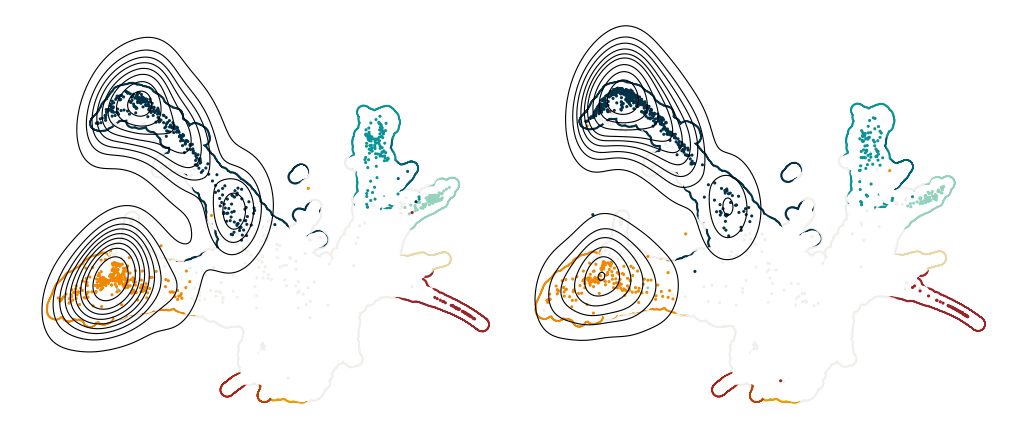

<IPython.core.display.Javascript object>

In [16]:
xf_ctrl = adata_ctrl[adata_ctrl.obs["t"] == 6]
xf_prtb = adata_prtb[adata_prtb.obs["t"] == 6]

force_zorder = {key: 110 for key in larry_cmap.keys()}
force_zorder = {
    "Neutrophil": 111,
    "Eos": 111,
    "Baso": 111,
    "Mast": 111,
    "Erythroid": 111,
    "Lymphoid": 111,
    "Monocyte": 111,
    "pDC": 111,
    "Ccr7_DC": 111,
    "Meg": 111,
    "Undifferentiated": 110,
    "undiff": 110,
}

xf_ctrl_subset = xf_ctrl[
    xf_ctrl.obs["Cell type annotation"].isin(["Monocyte", "Neutrophil"])
]
xf_prtb_subset = xf_prtb[
    xf_prtb.obs["Cell type annotation"].isin(["Monocyte", "Neutrophil"])
]

X_umap_ctrl = xf_ctrl_subset.obsm["X_umap"]
X_umap_prtb = xf_prtb_subset.obsm["X_umap"]

fig, axes = cp.plot(2, 2, height=1.1, width=1, del_xy_ticks=[True, True], delete="all")

_ = cp.umap_manifold(
    adata, groupby="Cell type annotation", c_background=larry_cmap, ax=axes[0]
)
_ = cp.umap_manifold(
    adata, groupby="Cell type annotation", c_background=larry_cmap, ax=axes[1]
)
ax0 = cp.umap(
    adata=xf_ctrl,
    cmap=larry_cmap,
    groupby="Cell type annotation",
    ax=axes[0],
    force_zorder=force_zorder,
    s=5,
)
sns.kdeplot(
    x=X_umap_ctrl[:, 0],
    y=X_umap_ctrl[:, 1],
    ax=axes[0],
    zorder=202,
    color="k",
    linewidths=0.8,
)
ax1 = cp.umap(
    adata=xf_prtb,
    cmap=larry_cmap,
    groupby="Cell type annotation",
    ax=axes[1],
    force_zorder=force_zorder,
    s=5,
)

sns.kdeplot(
    x=X_umap_prtb[:, 0],
    y=X_umap_prtb[:, 1],
    ax=axes[1],
    zorder=202,
    color="k",
    linewidths=0.8,
)
plt.savefig("Figure3AB.top_panels.svg", dpi=500)

In [14]:
def plot_temporal_counts(
    adata,
    obs_key: str,
    time_key: str = "t",
    cmap: Optional[Dict[str, str]] = None,
    ax: Optional[plt.Axes] = None,
    plot_kwargs: Optional[Dict[str, Any]] = {},
):

    if ax is None:
        fig, ax = cp.plot(**plot_kwargs)

    time_counts = (
        adata.obs.groupby(time_key)[obs_key].value_counts().unstack().fillna(0)
    )
    baseline = np.zeros(time_counts.shape[0])

    for col in time_counts:
        data = time_counts[col]
        y2 = baseline + data.values
        if cmap is None:
            color = None
        else:
            color = cmap[col]
        ax.fill_between(x=data.index, y1=baseline, y2=y2, color=color)
        baseline = baseline + data.values

<IPython.core.display.Javascript object>

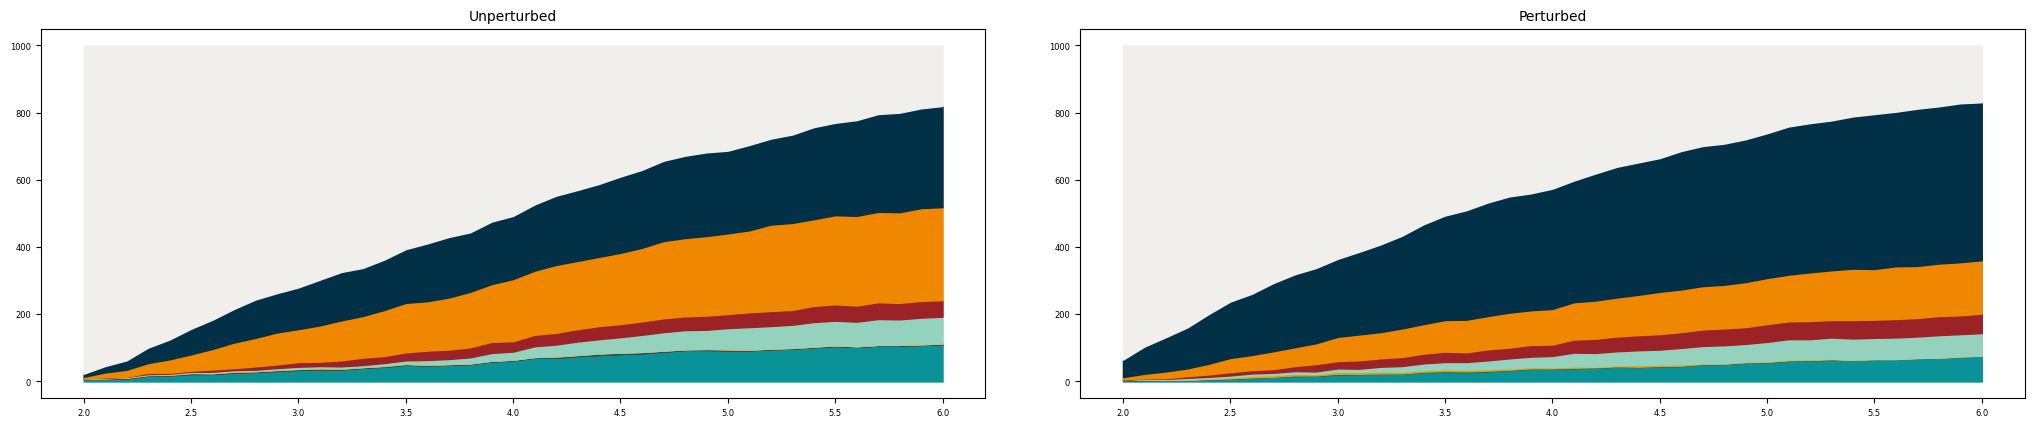

<IPython.core.display.Javascript object>

In [15]:
fig, axes = cp.plot(
    nplots=2, ncols=2, width=2, height=1, wspace=0.1, title=["Unperturbed", "Perturbed"]
)
plot_temporal_counts(
    adata_ctrl, obs_key="Cell type annotation", ax=axes[0], cmap=larry_cmap
)
plot_temporal_counts(
    adata_prtb, obs_key="Cell type annotation", ax=axes[1], cmap=larry_cmap
)
plt.savefig("Figure3AB.bottom_panels.svg", dpi=500)